# Prepare and preprocess data

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn import datasets
from sklearn.metrics import mean_absolute_error

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,Callback, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

/Users/yokoo/.pyenv/versions/anaconda3-5.0.0/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/yokoo/.pyenv/versions/anaconda3-5.0.0/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df_train = pd.read_csv('input/train.csv', index_col='datetime', parse_dates=[0])
df_train['month'] = df_train.index.month
df_train['day'] = df_train.index.day
df_train['weekday'] = df_train.index.weekday_name
df_train['week'] = df_train.index.week
df_train['year'] = df_train.index.year

syukujitsu = pd.read_csv('input/syukujitsu.csv')
syukujitsu = pd.to_datetime(syukujitsu['date'])
df_train['holiday'] = df_train['weekday'].isin(['Saturday', 'Sunday'])
df_train['holiday'] |= df_train.index.isin(syukujitsu)

df_train['weekday'] = df_train.index.weekday

def split_month_3(day):
    if day <= 10:
        return 0
    elif day > 10 and day <= 20:
        return 1
    else:
        return 2
        
df_train['month_split'] = df_train['day'].apply(split_month_3)
        
df_train['time_from_first'] = df_train[['year', 'month', 'day']].apply(
    lambda x: (x['year'] -2010) * 365 + x['month'] * 30 + x['day'], axis=1)
#df_train['time_from_first'] = (df_train['time_from_first'] - df_train['time_from_first'].mean()) / df_train['time_from_first'].std()
time_max = df_train['time_from_first'].max()
df_train['time_from_first'] /= time_max
df_train.drop('year', axis=1, inplace=True)

FileNotFoundError: File b'input/train.csv' does not exist

In [3]:
df_test = pd.read_csv('input/test.csv', index_col='datetime', parse_dates=[0])
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day
df_test['weekday'] = df_test.index.weekday_name
df_test['week'] = df_test.index.week
df_test['year'] = df_test.index.year

syukujitsu = pd.read_csv('input/syukujitsu.csv')
syukujitsu = pd.to_datetime(syukujitsu['date'])
df_test['holiday'] = df_test['weekday'].isin(['Saturday', 'Sunday'])
df_test['holiday'] |= df_test.index.isin(syukujitsu)

df_test['weekday'] = df_test.index.weekday

df_test['month_split'] = df_test['day'].apply(split_month_3)
df_test['time_from_first'] = df_test[['year', 'month', 'day']].apply(
    lambda x: (x['year'] -2010) * 365 + x['month'] * 30 + x['day'], axis=1)
df_test['time_from_first'] /= time_max
df_test.drop('year', axis=1, inplace=True)

In [4]:
df_train = df_train[df_train['close'] == 0]
df_train.drop('close', axis=1, inplace=True)

df_test_close = df_test[df_test['close'] == 1]
df_test = df_test[df_test['close'] == 0]
df_test.drop('close', axis=1, inplace=True)

In [5]:
y_train = df_train['y']
X_train = df_train.copy()
X_train.drop('y', axis=1, inplace=True)
X_test = df_test.copy()
X_train['holiday'] = X_train['holiday'].astype(int)
X_test['holiday'] = X_test['holiday'].astype(int)

In [6]:
X_train

,client,price_am,price_pm,month,day,weekday,week,holiday,month_split,time_from_first
datetime,,,,,,,,,,
2010-07-01,0,-1,-1,7,1,3,26,0,0,0.091302
2010-07-02,0,-1,-1,7,2,4,26,0,0,0.091735
2010-07-03,0,-1,-1,7,3,5,26,1,0,0.092168
2010-07-04,0,-1,-1,7,4,6,26,1,0,0.092601
2010-07-05,0,-1,-1,7,5,0,27,0,0,0.093033
2010-07-06,0,-1,-1,7,6,1,27,0,0,0.093466
2010-07-07,0,-1,-1,7,7,2,27,0,0,0.093899
2010-07-08,0,-1,-1,7,8,3,27,0,0,0.094331
2010-07-09,0,-1,-1,7,9,4,27,0,0,0.094764


In [7]:
def split_features(X):
    X_list = []

    client = X.iloc[:, 0].values
    X_list.append(client)

    price_am = X.iloc[:, 1].values + 1
    X_list.append(price_am)

    price_pm = X.iloc[:, 2].values + 1
    X_list.append(price_pm)
    
    month = X.iloc[:, 3].values - 1
    X_list.append(month)

    day = X.iloc[:, 4].values - 1
    X_list.append(day)
    
    weekday = X.iloc[:, 5].values
    X_list.append(weekday)

    week = X.iloc[:, 6].values - 1
    X_list.append(week)
    
    holiday = X.iloc[:, 7].values
    X_list.append(holiday)
    
#     month_split = X.iloc[:, [8]].values
#     X_list.append(month_split)

    time_from_first = X.iloc[:, 9].values
    X_list.append(time_from_first)
    
    return X_list


X_train_split = split_features(X_train)
X_test_split = split_features(X_test)

In [8]:
embed_dims = [1, 1, 1, 6, 10, 6, 10, 1]

inputs = []
layers = []
for feature, dim in zip(X_train_split, embed_dims):
    input_layer = Input(shape=(1,), dtype='int32')
    x = Embedding(len(np.unique(feature)), dim, input_length=1)(input_layer)
    x = Reshape(target_shape=(dim,))(x)    
    inputs.append(input_layer)
    layers.append(x)
    
# time_from_first
layer_time_from_first = Input(shape=(1,), dtype='float32')
inputs.append(layer_time_from_first)
layers.append(layer_time_from_first)

x = concatenate(layers)
x = Dense(1000, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mean_absolute_error', optimizer=Adam(1e-4))

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [9]:
model.fit(X_train_split, y_train, epochs=12, batch_size=32)

Epoch 1/12
2074/2074 [==============================] - 1s - loss: 31.7850      

In [10]:
pred_train = model.predict(X_train_split).flatten()
pred_test = model.predict(X_test_split).flatten()

In [11]:
df_test['y'] = pred_test
df_test_close['y'] = 0
df_pred = pd.concat([df_test['y'], df_test_close['y']]).sort_index()
df_sample = pd.read_csv('input/sample_submit.csv', header=None)
df_sample.iloc[:, 1] = df_pred.values
df_sample.to_csv('submit/submit.csv', header=None, index=False)

In [18]:
def embed_feature(X, w, nb_cat):
    X -= X.min()
    onehot = np.eye(nb_cat)[X]
    return onehot @ w

features_train = []
features_test = []
for i in range(8):
    nb_cat = len(np.unique(X_train.iloc[:, i]))
    embedded_train = embed_feature(X_train.iloc[:, i], K.eval(model.weights[i]), nb_cat)
    features_train.append(embedded_train)
    embedded_test = embed_feature(X_test.iloc[:, i], K.eval(model.weights[i]), nb_cat)
    features_test.append(embedded_test)

features_train.append(np.expand_dims(X_train.iloc[:, 9].values, axis=-1))
features_test.append(np.expand_dims(X_test.iloc[:, 9].values, axis=-1))
X_train_embeded = np.concatenate(features_train, axis=1)
X_test_embeded = np.concatenate(features_test, axis=1)

In [13]:
xgb_model = xgb.XGBRegressor()

params = {
    "learning_rate": [2e-1, 1e-1, 5e-2, 1e-2],
    "max_depth": sp.stats.randint(4, 10),
    "subsample": sp.stats.uniform(0.5, 0.5),
    "colsample_bytree": sp.stats.uniform(0.5, 0.5),
    "min_child_weight": sp.stats.randint(4, 10),
    "n_estimators": sp.stats.randint(20, 100),
}

rs = RandomizedSearchCV(xgb_model,
                        params,
                        cv=3,
                        n_iter=300,
                        scoring="neg_mean_absolute_error",
                        n_jobs=1,
                        verbose=1)

rs.fit(X_train_embeded, y_train)
#model.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  4.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=300, n_jobs=1,
          param_distributions={'learning_rate': [0.2, 0.1, 0.05, 0.01], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x129022f98>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x129022080>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x129034438>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1290346d8>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1290344

In [14]:
rs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.78156096522796614, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=7, min_child_weight=7, missing=None,
       n_estimators=69, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.60358925065576718)

In [15]:
model = xgb.XGBRegressor(**rs.best_params_)
model.fit(X_train_embeded, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.78156096522796614, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=7, min_child_weight=7, missing=None,
       n_estimators=69, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.60358925065576718)

In [16]:
pred_train = model.predict(X_train_embeded)
pred_test = model.predict(X_test_embeded)
mean_absolute_error(pred_train, y_train)

1.856704469816894

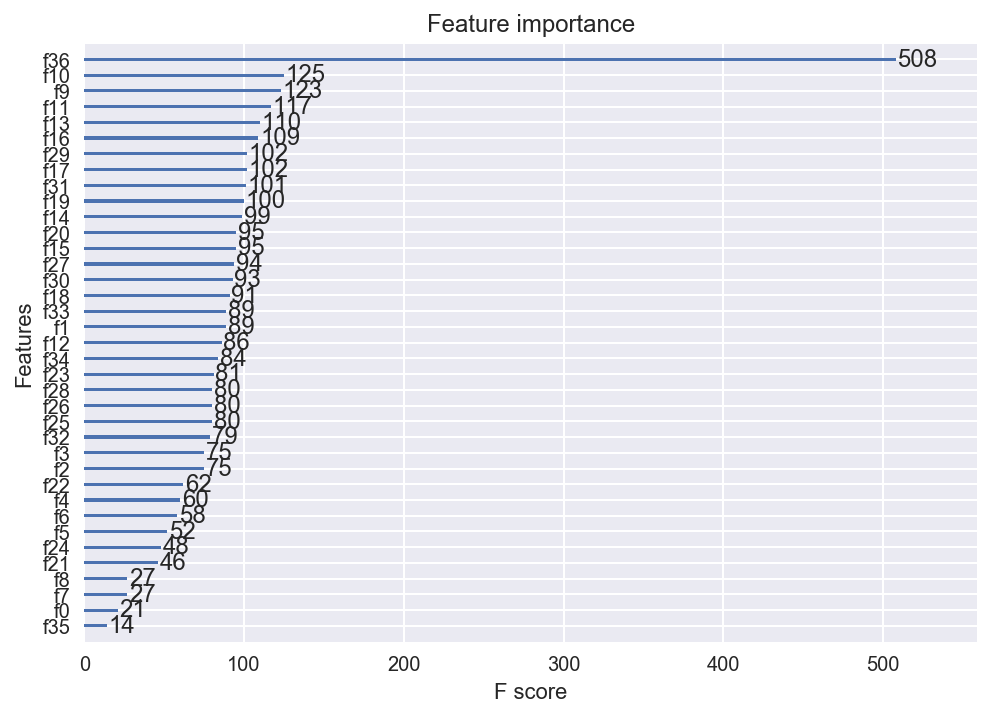

In [17]:
df_test['y'] = pred_test
df_test_close['y'] = 0
df_pred = pd.concat([df_test['y'], df_test_close['y']]).sort_index()
df_sample = pd.read_csv('input/sample_submit.csv', header=None)
df_sample.iloc[:, 1] = df_pred.values
df_sample.to_csv('submit/submit.csv', header=None, index=False)
xgb.plot_importance(model)

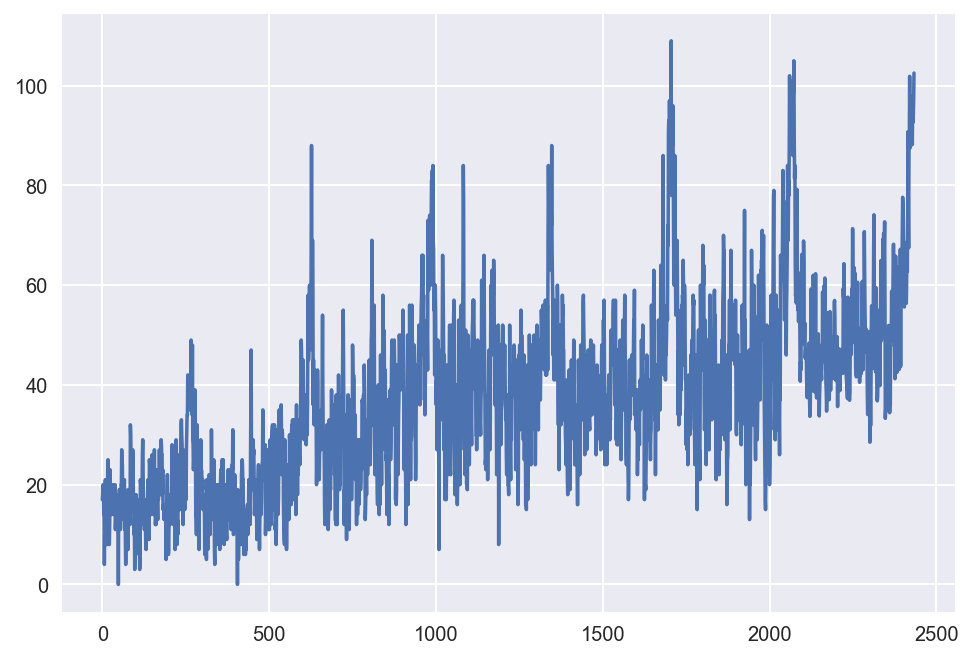

In [18]:
plt.plot(np.concatenate([y_train, pred_test]))

In [23]:
 K.eval(model.weights[6]).shape

(53, 10)

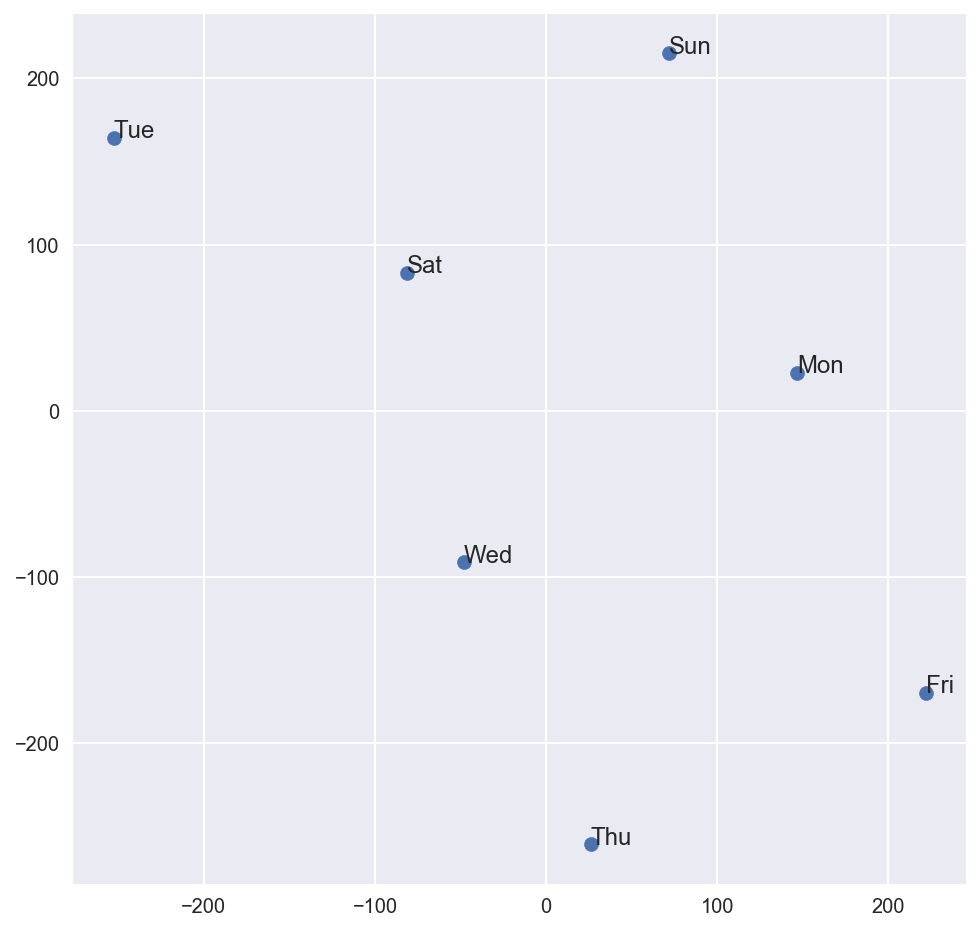

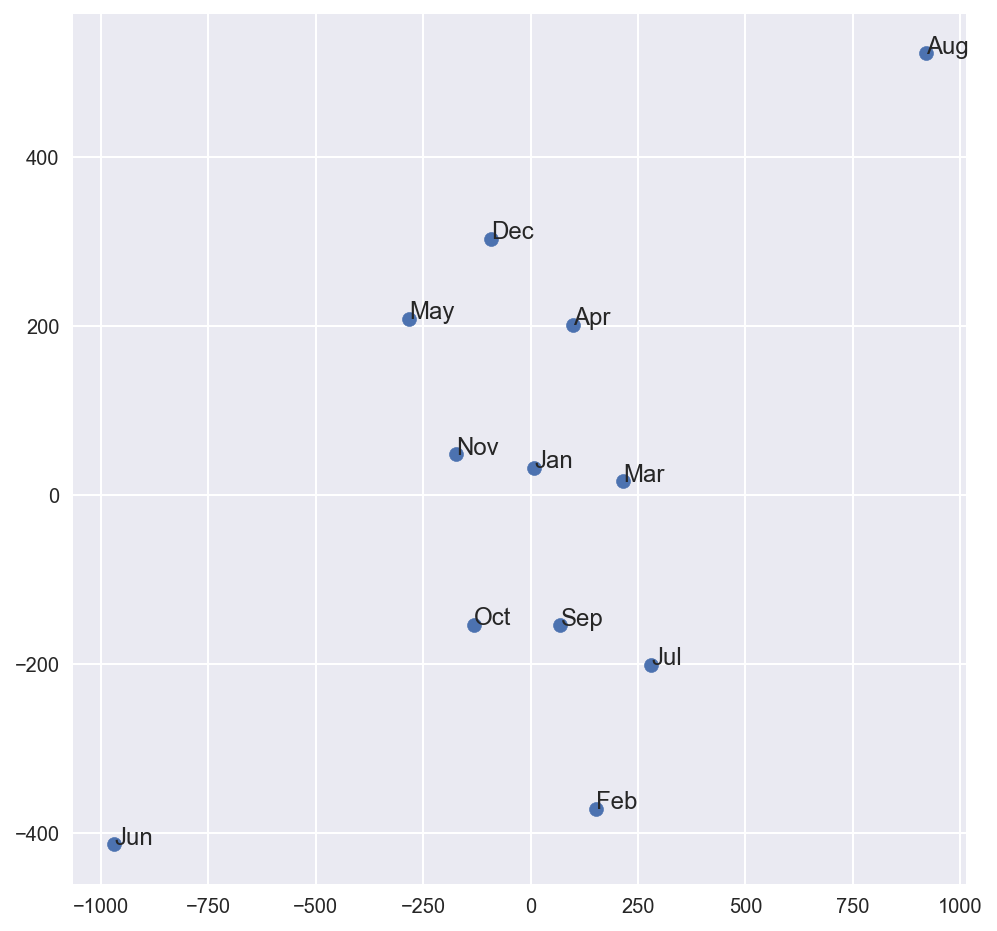

In [24]:
import pickle
from sklearn import manifold

dow_embedding = K.eval(model.weights[5])
month_embedding = K.eval(model.weights[3])

tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(dow_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']

# plot する
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))

plt.savefig('dow_embedding.png')

# 月
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(month_embedding)
names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))

plt.savefig('month_embedding.png')